In [98]:
import numpy as np
import scipy.io
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from sklearn.metrics import f1_score
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

Les données sont 36 eeg avec certains egge "anormaux" et d'autres "normaux"

data from https://www.kaggle.com/datasets/amananandrai/complete-eeg-dataset/data

durée = 60s


freq = 516 Hz

In [4]:
labels=np.array([0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1])
len(labels)

36

La ce que je fais c'est que je découpe chaque eeg en petits patchs de 1000 points. La tache de classification sera de prendre un patch de 1000 points et de le classifier en malade / non malade

In [6]:
# set construct_files to True if you want to construct the files
construct_files = False
if construct_files : 
    np.random.seed(0)
    counts = [str(i) for i in range(31)]
    counts = ['0' + i if len(i) == 1 else i for i in counts]

    for file_name in counts : 
        df = pd.read_csv('./../data/kaggle_2/s'+file_name+'.csv', header=None).transpose().to_numpy()
        for i in range(31*4): 
            sample = pd.DataFrame(df[:, 250*i:250*i+1000]) # slicing of 250 
            random_float = np.random.rand()
            if random_float < 0.1:
                sample.to_csv('./../data/test/'+file_name+'_'+str(i)+'_'+'.csv', index=False, header=False)
            elif random_float < 0.3 : 
                sample.to_csv('./../data/validation/'+file_name+'_'+str(i)+'_'+'.csv', index=False, header=False)
            else:
                sample.to_csv('./../data/train/'+file_name+'_'+str(i)+'_'+'.csv', index=False, header=False)
            


Dans la cellule suivante, je définis un dataset pretraining. La tache de pretraining consiste à prendre deux patchs de longueur 1000 dans un même eeg et de dire s'ils sont à côté ou non. 

Ainsi, on découpe chaque eeg en patchs glissants de taille 1000 et glissant de 250 à chaque fois. Ca fait 31*4 - 4 = 120 patchs. __getitem__ renvoie soit un patch et son voisin de droite à 500 points, soit un patch et le patch situé à 15500 points de lui (on rapelle que les eeg font 31 000 points). En plus de cela, il renvoie les indices des deux patchs (pour la classification)

In [8]:
class Dataset_pretraining(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_files=36, n_samples_per_file=31*4, segment_length=1000, slide = 250):
        self.path_to_data = path_to_data
        self.n_files = n_files
        self.slide = slide
        self.n_samples_per_file = n_samples_per_file
        self.segment_length = segment_length
        self.data = []
        for file in range(self.n_files):
            x = pd.read_csv(self.path_to_data + 's' + str(file).zfill(2) + '.csv', header=None).transpose().to_numpy()
            self.data.append(x)

    def __len__(self):
        return self.n_files * self.n_samples_per_file*2

    def __getitem__(self, idx):
        file = idx // ((31*4)*2)
        sample = (idx % ((31*4)*2))
        first = (sample % (31*4))*250
        if first+1000 >= 31000:
            first = 30000-1
        if sample // (31*4) == 0:  # proches, second est une fenêtre proche de first
            if first + 1500 > 31000:
                second  = first  - 500
            else : 
                second = first + 500
        else: # éloignés, second est une fenêtre éloignée de first
            assert sample // (31*4) == 1
            second = first + 15500
            if second + 1000 > 31000:
                second = 15500
        x1 = self.data[file][:, first: first+self.segment_length]  # Utilisation de la donnée préchargée
        x2 = self.data[file][:, second: second+self.segment_length]
        return torch.stack([torch.tensor(x1), torch.tensor(x2)]), torch.tensor([first, second])


Dans la cellule suivante, on définit le dataset pour la tache finale de classification. On renvoie un sous_eeg de 1000 points ainsi que le label auquel il est associé. 

In [48]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data # par example './../data/train/
        self.X = os.listdir(self.path_to_data) # the list of the files in the train set 
        self.data=[]
        self.labels=np.array([0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1])
        for idx in range(len(self.X)):
            x = pd.read_csv(self.path_to_data + self.X[idx], header=None).to_numpy()
            self.data.append((x, self.labels[int(self.X[idx].split('_')[0])]))


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x , y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

Next cell to build the dataloaders. J'ai fait n'imp sur les dataloaders train, val et test donc ça prend un temps fou à charger; 

In [49]:
dataloader_train = DataLoader(Mydataset('./../data/train/'), batch_size=5, shuffle=True)
print('train finished')
dataloader_val = DataLoader(Mydataset('./../data/validation/'), batch_size=5, shuffle=True)
print('val finished')
dataloader_test = DataLoader(Mydataset('./../data/test/'), batch_size=5, shuffle=True)
print('test finished')
dataloader_pretraining = DataLoader(Dataset_pretraining('./../data/kaggle_2/'), batch_size=1, shuffle=True)

train finished
val finished
test finished


In [32]:
for batch in dataloader_pretraining :
  print(batch[0].shape)
  print(batch[1].shape)
  break
print('--------------------')
for batch in dataloader_train :
  print(batch[0].shape)
  print(batch[1].shape)
  break

torch.Size([1, 2, 19, 1000])
torch.Size([1, 2])
--------------------
torch.Size([5, 19, 1000])
torch.Size([5])


La c'est notre feature extractor, convolutionnel grosso modo comme ce qu'on a dans l'article. 

In [33]:
class EEGFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=100):
        super(EEGFeatureExtractor, self).__init__()
        # input [batch_size, 19, 1000]
        self.conv1= nn.Conv1d(19, 32, 3, padding=1)
        self.conv2= nn.Conv1d(32, 64, 3, padding=1)
        self.conv3= nn.Conv1d(64, 128, 3, padding=1)
        self.conv4= nn.Conv1d(6, 10, 3, padding=1)   
        self.conv5 = nn.Conv1d(64, 15, 3, padding=1)
        self.pool = nn.MaxPool1d(1, 13)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(150, 100)
        self.relu = nn.ReLU()

    def forward(self, x):
        # print('au début', x.shape)
        x = self.relu(self.conv1(x))
        # print(1, x.shape)
        x = self.pool(x)
        # print(2, x.shape)
        x = self.relu(self.conv2(x))
        # print(3, x.shape)
        x = self.pool(x)
        # print(4, x.shape)
        x = torch.transpose(x, 1, 2)
        # print(5, x.shape)
        x = self.relu(self.conv4(x))
        # print(6, x.shape)
        x = torch.transpose(x, 1, 2)
        # print(7, x.shape)
        x = self.conv5(x)
        # print(8, x.shape)
        x = x.flatten(start_dim=1)
        # print(9, x.shape)
        x = self.dropout(x)
        # print('a la fin', x.shape)
        x = self.fc(x)
        return self.relu(x)


In [34]:
for batch in dataloader_train :
  x = batch[0]
  print(x.shape)
  model = EEGFeatureExtractor()
  print(model(x.float()).shape)  
  break

torch.Size([5, 19, 1000])
torch.Size([5, 100])


On entraine le features extractor : 


In [39]:
chemin_vers_sauvegarde = './models/'

In [35]:
train_extractor = False
tau = 516 # 1 seconde
model_name='extractor'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cpu'
model = EEGFeatureExtractor()
n_epochs=200
loss = torch.nn.L1Loss()
param_1 = torch.nn.Parameter(torch.ones(100, requires_grad=True))
param_2 =  torch.nn.Parameter(torch.ones(1, requires_grad=True))
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(
    [{'params': model.parameters()}, {'params': [param_1, param_2]}],
    lr=0.1
)
model.to(device)
loss_train=[]
if train_extractor:
    for epoch in (range(n_epochs)):
        print('epoch', epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_pretraining:
            batch_x=batch_x[0].to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            first_window = batch_x[0]
            second_window = batch_x[1]
            # print('the shape is', first_window.float().shape)
            first_prediction = model(first_window.float().unsqueeze(0))
            second_prediction = model(second_window.float().unsqueeze(0))
            label_predicted = torch.dot(param_1, abs(first_prediction - second_prediction).squeeze()) + param_2
            idx_1 = batch_y[0][0]
            idx_2 = batch_y[0][1]
            if (
                
                abs(idx_1- idx_2 ) < 1000 # close in time
            ) : 
                y_pred = torch.tensor([-1]).to(device)
            else:
                y_pred = torch.tensor([1]).to(device) # 1 s'ils sont proches, -1 sinon
            l=-torch.nn.functional.logsigmoid(y_pred * label_predicted)
            # l=torch.log(1+torch.exp(-y_pred*label_predicted))
            counttrain+=1
            l.backward()
            losstrain+=l
            optimizer.step()
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
        loss_train.append(losstrain/counttrain)
        
    torch.save(model, chemin_vers_sauvegarde+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]



    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

c:\Users\grego\miniconda3\envs\map588\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Là hop le classifieur, qui est constitué d'un feature extractor puis d'une couche fully connected. Soit on entraine tout d'un coup soit on entraine séparément les deux parties

In [37]:
class EEGClassifier(nn.Module):
    def __init__(self, feature_extractor):
        super(EEGClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.fc(features)


La c'est les boucles d'entrainement qui sont aussi dans le fichier .py

In [ ]:
pretrained = torch.load('./models/extractor.pth')
for param in pretrained.parameters():
    param.requires_grad = False
model = EEGClassifier(pretrained)
# loss for classification : 
loss = torch.nn.BCEWithLogitsLoss()
model_name = 'classifier_pretrained'
loss_train=[]
n_epochs=200
optimizer = torch.optim.Adam(model.fc.parameters())
for epoch in range(n_epochs):
    print('epoch', epoch)
    losstrain=0
    counttrain=0
    for batch_x,batch_y in dataloader_train:
        batch_x=batch_x.to(device)
        batch_y = batch_y.float()
        batch_y=batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_x.float())
        l=loss(y_pred.squeeze(), batch_y)
        counttrain+=1
        l.backward()
        losstrain+=l
        optimizer.step()
    if epoch%10==0:
        print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
    loss_train.append(losstrain/counttrain)
torch.save(model, chemin_vers_sauvegarde+model_name+'_final'+'.pth')
loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]
with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
    for elt in loss_list_train : 
        f.write(str(elt) + '\n')


In [ ]:
not_pretrained = EEGFeatureExtractor()
model = EEGClassifier(not_pretrained)
loss = torch.nn.BCEWithLogitsLoss()
n_epochs=200
optimizer = torch.optim.Adam(model.parameters())
model_name = 'classifier_not_pretrained'
loss_train=[]
loss = torch.nn.BCEWithLogitsLoss()
n_epochs=200
# optimizer = torch.optim.Adam(model.fc.parameters())
for epoch in range(n_epochs):
    print('epoch', epoch)
    losstrain=0
    counttrain=0
    for batch_x,batch_y in dataloader_train:
        batch_x=batch_x.to(device)
        batch_y = batch_y.float()
        batch_y=batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_x.float())
        l=loss(y_pred.squeeze(), batch_y)
        counttrain+=1
        l.backward()
        losstrain+=l
        optimizer.step()
    if epoch%10==0:
        print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
    loss_train.append(losstrain/counttrain)
torch.save(model, chemin_vers_sauvegarde+'_final'+'.pth')
loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]
with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
    for elt in loss_list_train : 
        f.write(str(elt) + '\n')


Dernière cellule pour l'évaluation finale !!

In [148]:
model = torch.load('./models/classifier_pretrained_final_bis.pth')
for batch_x, batch_y in dataloader_test : 
    batch_x = batch_x.to(device)
    batch_y = batch_y.float()
    batch_y = batch_y.to(device)
    y_pred = model(batch_x.float())
    print(y_pred)
    break


tensor([[2.2209e+15],
        [1.5436e+15],
        [1.2120e+15],
        [1.3875e+15],
        [1.9200e+15]], grad_fn=<AddmmBackward0>)


In [142]:
pretrained = torch.load('./models/classifier_pretrained_final_bis.pth')
not_pretrained = torch.load('./models/classifier_not_pretrained.pth')
y_true =np.array( [])
y_pred_pretrained = np.array( [])
y_pred_not_pretrained = np.array( [])
for batch_x, batch_y in dataloader_val:
    batch_x = batch_x.to(device)
    batch_y = batch_y.float()
    batch_y = batch_y.to(device)
    y_pretrained = pretrained(batch_x.float())
    y_not_pretrained = not_pretrained(batch_x.float())
    y_true=np.concatenate((y_true, batch_y.numpy()))
    y_pretrained = y_pretrained.detach().numpy()
    y_not_pretrained = y_not_pretrained.detach().numpy()
    y_pred_pretrained=np.concatenate((y_pred_pretrained, y_pretrained.flatten()))
    y_pred_not_pretrained=np.concatenate((y_pred_not_pretrained, y_not_pretrained.flatten()))

y_pred_pretrained = (y_pred_pretrained > 0.5).astype(int)
y_pred_not_pretrained = (y_pred_not_pretrained > 0.5).astype(int)
print('F1 score pretrained', f1_score(y_true, y_pred_pretrained))
print('F1 score not pretrained', f1_score(y_true, y_pred_not_pretrained))


F1 score pretrained 0.8117782909930715
F1 score not pretrained 0.7786732796032237


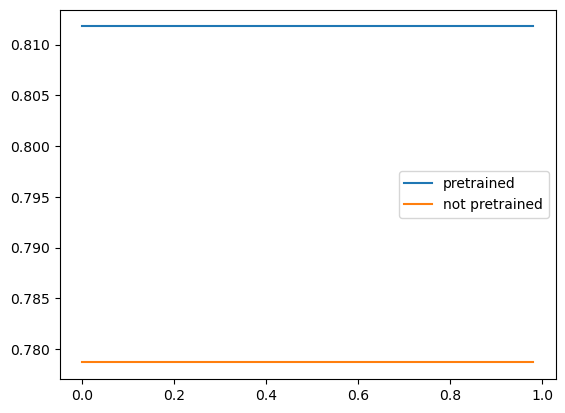

In [144]:
les_pretrained= []
les_not_pretrained = []
for threshold in np.arange(0, 1, 0.02):
    y_pred_pretrained_oui = (y_pred_pretrained > threshold).astype(int)
    y_pred_not_pretrained_oui = (y_pred_not_pretrained > threshold).astype(int)
    les_pretrained.append(f1_score(y_true, y_pred_pretrained_oui))
    les_not_pretrained.append(f1_score(y_true, y_pred_not_pretrained_oui))
plt.plot( np.arange(0, 1, 0.02),les_pretrained,  label='pretrained')
plt.plot( np.arange(0, 1, 0.02),   les_not_pretrained,   label='not pretrained')
plt.legend()
plt.show()

In [126]:
model = torch.load('./models/extractor.pth')
for batch_x, batch_y in dataloader_test : 
    # print(batch_x)
    print(model(batch_x.float()))
    break

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   